In [1]:
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from scipy.sparse import csr_matrix
os.chdir(os.path.expanduser('~/vEcoli'))

In [2]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

# data from Cyrus:
Cmatrix = read_matrix("notebooks/mia_notebooks/protein_count_comparison_files/C_matrix.csv", sparse=True)
complex_ids = list(read_names("notebooks/mia_notebooks/protein_count_comparison_files/complex_ids.txt"))
monomer_ids = list(read_names("notebooks/mia_notebooks/protein_count_comparison_files/monomer_ids.txt"))

# Ecocyc data (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI): 
ecocyc_data = pd.read_excel("notebooks/mia_notebooks/protein_count_comparison_files/All_polypeptides_from_ecocyc_data.xlsx")

# validation data (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_data = pd.read_excel("notebooks/mia_notebooks/protein_count_comparison_files/data_from_li_et_al_2014.xlsx")

## Minimal Media Conditions Comparison: Simulation data VS "MOPS minimal" data from Li et al., 2014 

In [3]:
#todo figure out why this no longer works!! for some reason it appears the bulk data is missing things?
# time = '1300'
# date = '2024-04-29'
# experiment = 'validation_experiment'
# entry = f'{experiment}_{time}_{date}'
# folder = f'out/cofactors/{entry}/'

In [4]:
# new data from simulation on 2024-07-16
time = '1300'
date = '2024-07-16'
experiment = 'metabolism-redux-classic'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [5]:
output_all = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pl.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

ans = output['listeners']['unique_molecule_counts']['active_ribosome']

In [6]:
# So say I want to find the names of the proteins themselves, these are functions to implement that do so: 
# TODO ask cyrus about this 
initial_state = json.load(open('data/wcecoli_t0.json'))

bulk_ids = [item[0] for item in initial_state['bulk']]

bulk.columns = bulk_ids

In [7]:
#bulk_ids

In [8]:
np.shape(bulk.columns) # 16097

(16255,)

In [9]:
# Combine monomers in different compartments into one monomer id: 
id_idx_dict = {id: i for i, id in enumerate(bulk_ids)}
idx_id_dict = {idx: i for i, idx in id_idx_dict.items()}

# take the protein [location] out of the name of the bulk ids: 
ecocyc_ids = []
for id in bulk_ids: 
	ecocyc_ids.append(id[0:-3])

ecocyc_id_idxs = []
for i in range(len(ecocyc_ids)):
	ecocyc_id_idxs.append(i)
	
all_names = [] # ends with 12726 total (down from 16097)
name_groups = []
idx_groups = []

for p in bulk_ids:
	prot = p[0:-3]
	if prot not in all_names:
		indexes = [index for index, item in enumerate(ecocyc_ids) if item == prot]
		for idx in indexes:
			if ecocyc_ids[idx] == prot:
				# confirm the index is correct
				pass
			else:
				# delete the index in case a mistake was made
				indexes.remove(idx)
		name_group = [idx_id_dict.get(name) for name in indexes]
		all_names.append(prot)
		name_groups.append(name_group)
		idx_groups.append(indexes)
		
len(all_names)
len(name_groups)

12788

In [10]:
# figure out which proteins from the C matrix match those in the bulk data: 
protein_ids = complex_ids + monomer_ids
protein_counts = np.zeros([bulk.shape[0], len(protein_ids)])
pid_idx_dict = {id: i for i, id in enumerate(protein_ids)}
idx_pid_dict = {idx: i for i, idx in pid_idx_dict.items()}

for p in protein_ids:
	idx = [index for index, item in enumerate(all_names) if item == p]
	if len(idx) == 0:
		protein_counts[:, pid_idx_dict[p]] = 0
	elif len(idx) == 1:
		name = all_names[idx[0]]
		idx_group = idx_groups[idx[0]]
		temp_counts = np.zeros([bulk.shape[0], len(idx_group)])
		for i in range(len(idx_group)):
			selected_data = bulk.select(bulk_ids[idx_group[i]]) 
			temp_counts[:, i] = selected_data.to_numpy().flatten()
		protein_counts[:, pid_idx_dict[p]] = np.sum(temp_counts, axis=1)
	else:
		# make sure there are no bugs in the code
		print(p)
		print("too many")
	

In [11]:
np.shape(protein_counts)

(1301, 5527)

In [12]:
mm_sim_protein_counts = protein_counts @ Cmatrix
# simplify the results accordingly with the time steps: 
mm_avg_sim_data = mm_sim_protein_counts.mean(axis=0)
# TODO: edit this to account for cell age
# create dataframes for the simulation data:
mm_avg_sim_df = pl.DataFrame((monomer_ids, mm_avg_sim_data), schema=["Monomer ID","Sim Protein Counts"])

In [13]:
mm_avg_sim_df

Monomer ID,Sim Protein Counts
str,f64
"""1-ACYLGLYCEROL-3-P-ACYLTRANSFE…",176.874712
"""1-PFK-MONOMER""",57.001537
"""2-DEHYDROPANTOATE-REDUCT-MONOM…",217.187548
"""2-ISOPROPYLMALATESYN-MONOMER""",1630.80784
"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…",322.077633
…,…
"""YTFR-MONOMER""",25.0
"""YTFT-MONOMER""",21.0
"""ZNUA-MONOMER""",570.823213


In [14]:
new_df = pl.DataFrame(ecocyc_data).join(mm_avg_sim_df,  how="inner", left_on="Proteins", right_on="Monomer ID")
# TODO: so the length of the original ecocyc data frame is 4481, so I think that it is filtering correctly! 
new_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts
str,str,str,str,f64
"""EG11817-MONOMER""","""EG11817""","""b2744""","""umpG""",88.013067
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",262.318217
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",22.0
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB""",195.0
"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623""","""add""",171.176018
…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",73.601845
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD""",296.885473
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr""",19.0


In [15]:
# Remove rows from validation_data that do not have high confidence (they will contain brackets) in the "MOPS complete" column:
validation_data['MOPS minimal'] = validation_data['MOPS minimal'].astype(str)
validation_data = validation_data[~validation_data['MOPS minimal'].str.contains("[", regex=False)]
validation_data = validation_data[validation_data['MOPS minimal'].str.isdigit()]
validation_data['MOPS minimal'] = validation_data['MOPS minimal'].astype(int)
v_mm_data = validation_data[['Gene', 'MOPS minimal']]
v_mm_data = pl.DataFrame(v_mm_data)
v_mm_data

Gene,MOPS minimal
str,i64
"""aaeA""",5
"""aaeR""",79
"""aas""",80
"""aat""",111
"""abgA""",12
…,…
"""zraR""",30
"""zraS""",4
"""zupT""",217


In [16]:
# find matches between the simulation minimal media data and validation minimal media data: 
vs_match_mm_df = pl.DataFrame(new_df).join(v_mm_data,  how="inner", left_on="Common-Name", right_on="Gene")
vs_match_mm_df

Proteins,Genes,Accession-1 of Gene,Common-Name,Sim Protein Counts,MOPS minimal
str,str,str,str,f64,i64
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB""",262.318217,572
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI""",22.0,16
"""ADENODEAMIN-MONOMER""","""EG10030""","""b1623""","""add""",171.176018,265
"""EG10875-MONOMER""","""EG10875""","""b3310""","""rplN""",11426.142967,18836
"""G6605-MONOMER""","""G6605""","""b1165""","""ymgA""",27.679477,43
…,…,…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ""",73.601845,19
"""GALACTITOLPDEHYD-MONOMER""","""EG12417""","""b2091""","""gatD""",296.885473,2360
"""EG10736-MONOMER""","""EG10736""","""b0708""","""phr""",19.0,37


In [26]:
# make a new data frame that holds just the protein names and the Sim Protein Counts and MOPS minimal data and then filter out counts that are less than 10: 
comparison_data = ["Proteins", "Sim Protein Counts", "MOPS minimal"]
comparison_df = vs_match_mm_df.select(comparison_data)
comparison_df = comparison_df.rename({"Proteins": "Protein ID"})
comparison_df = comparison_df.filter((pl.col("Sim Protein Counts") > 10) & (pl.col("MOPS minimal") > 10))
comparison_df

Protein ID,Sim Protein Counts,MOPS minimal
str,f64,i64
"""MONOMER0-4534""",262.318217,572
"""FDOI-MONOMER""",22.0,16
"""ADENODEAMIN-MONOMER""",171.176018,265
"""EG10875-MONOMER""",11426.142967,18836
"""G6605-MONOMER""",27.679477,43
…,…,…
"""G7835-MONOMER""",73.601845,19
"""GALACTITOLPDEHYD-MONOMER""",296.885473,2360
"""EG10736-MONOMER""",19.0,37


In [18]:
np.shape(comparison_df)

(2656, 3)

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data')

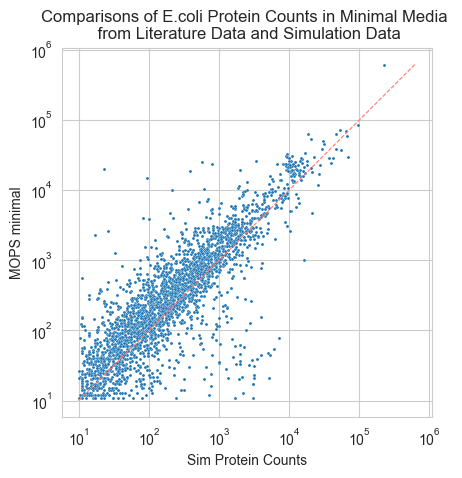

In [19]:
# plot the comparison graph:
sns.scatterplot(x="Sim Protein Counts", y="MOPS minimal", data=comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(comparison_df["Sim Protein Counts"]), max(comparison_df["MOPS minimal"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of E.coli Protein Counts in Minimal Media \n from Literature Data and Simulation Data")

## normalization of the data

Normalize by calculating the sum of the Sim Protein counts and the MOPS complete counts and then dividing each value by the total sum of the respective counts.
To normalize to one, also multiply the ((MOPS complete)/(total MOPS complete counts) by the total sum of the Sim Protein counts.

Thus, normalized would look like this: 
normalized Sim Protein Counts: $$Sim Protein Counts$$
normalized MOPS complete Counts: $$\frac{MOPS complete}{\sum_{i=1}^{n} MOPS complete} \times \sum_{i=1}^{n} Sim Protein Counts$$

In [28]:
# get the sum of the total sim protein counts and the total MOPS complete counts:
total_sim_protein_counts = comparison_df["Sim Protein Counts"].sum()
total_mm_complete_counts = comparison_df["MOPS minimal"].sum()

# normalize the data:
mm_comparison_df = comparison_df.with_columns(
	((comparison_df["Sim Protein Counts"] )).alias("Sim Protein Counts"),
	((comparison_df["MOPS minimal"] / total_mm_complete_counts) * total_sim_protein_counts).alias("MOPS minimal"))

Text(0.5, 1.0, 'Comparisons of $\t{E. coli}$ Protein Counts in Minimal Media \n from Literature Data (Li, et. al., 2014) and Simulation Data')

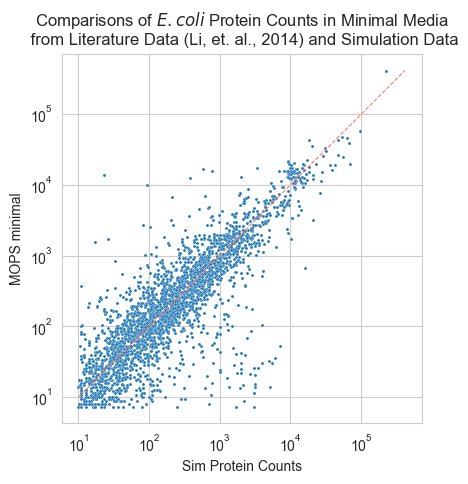

In [29]:
# plot the comparison graph:
sns.scatterplot(x="Sim Protein Counts", y="MOPS minimal", data=mm_comparison_df.to_pandas(), s=5)

# find the max value of the plot for making a y=x line: 
max_vals = [max(mm_comparison_df["Sim Protein Counts"]), max(mm_comparison_df["MOPS minimal"])]; max_val = round(max(max_vals))
yxvals = range(10, max_val + 1); 
plt.plot(yxvals, yxvals, linewidth=.8, linestyle="dashed", color="#FF796C"); 

# plot specs
plt.xscale('log')
plt.yscale('log')
plt.axis('square')
plt.title("Comparisons of $\t{E. coli}$ Protein Counts in Minimal Media \n from Literature Data (Li, et. al., 2014) and Simulation Data")

# Metal interactions

In [30]:
# load in data frame that lists protein + metal ion interations:
protein_metal_data = pd.read_csv("notebooks/mia_notebooks/protein_count_comparison_files/metal_protein_interaction_df.csv")
protein_metal_data

# todo: note this data has way more proteins than the comparison data has because it also has all the complexes listed!

,FE,ZN,MN,CU,MO,NI,CO,Protein ID
0,0,0,0,0,0,0,0,1-PFK
1,0,0,0,0,0,0,0,2OXOGLUTARATEDEH-CPLX
2,0,0,0,0,0,0,0,3-ISOPROPYLMALDEHYDROG-CPLX
3,4,0,0,0,0,0,0,3-ISOPROPYLMALISOM-CPLX
4,0,0,0,0,0,0,0,3-METHYL-2-OXOBUT-OHCH3XFER-CPLX
...,...,...,...,...,...,...,...,...
5522,0,0,0,0,0,0,0,YTFR-MONOMER
5523,0,0,0,0,0,0,0,YTFT-MONOMER
5524,0,1,0,0,0,0,0,ZNUA-MONOMER
5525,0,0,0,0,0,0,0,ZNUB-MONOMER


In [31]:
# DETERMINE WHICH PROTEINS HAVE METAL INTERACTIONS
# todo: did I take out all the compelxes from the protein_metal_data df? Becuase I should have! I think I do in the function on line 8

# determine which proteins in the comparison data have metal interactions and which do not:
interaction_df = pl.DataFrame(protein_metal_data[["Protein ID", "FE", "ZN", "MN", "CU", "MO", "NI", "CO"]])

# find the proteins that are cross listed between the comparison data and the metal interaction data:
def find_cross_listed_proteins(interaction_df, comparison_df):
	# Filter out proteins with metal interactions:
	cross_listed_df = pl.DataFrame(comparison_df).join(interaction_df, how="inner", on="Protein ID")
	cross_listed_df = cross_listed_df.drop(["Sim Protein Counts", "MOPS minimal"])
	return cross_listed_df

# find the proteins that are in the dataset and have metal interactions: 
cross_listed_df = find_cross_listed_proteins(interaction_df, mm_comparison_df)

# Define the columns of interest
metal_columns = ['FE', 'ZN', 'MN', 'CU', 'MO', 'NI', 'CO']

# Add a new column that counts the nonzero values for each Protein ID across the metal columns
cross_listed_df_with_counts = cross_listed_df.with_columns(
    (pl.sum_horizontal([pl.col(col) != 0 for col in metal_columns])).alias("nonzero_count"))
cross_listed_df_with_counts

Protein ID,FE,ZN,MN,CU,MO,NI,CO,nonzero_count
str,i64,i64,i64,i64,i64,i64,i64,u32
"""1-ACYLGLYCEROL-3-P-ACYLTRANSFE…",0,0,0,0,0,0,0,0
"""1-PFK-MONOMER""",0,0,0,0,0,0,0,0
"""2-DEHYDROPANTOATE-REDUCT-MONOM…",0,0,0,0,0,0,0,0
"""2-ISOPROPYLMALATESYN-MONOMER""",0,0,0,0,0,0,0,0
"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…",0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…
"""YRBG-MONOMER""",0,0,0,0,0,0,0,0
"""YTFQ-MONOMER""",0,0,0,0,0,0,0,0
"""ZNUA-MONOMER""",0,1,0,0,0,0,0,1


# Determine the metal interactions by interaction type

In [32]:
# find proteins that have at least one interaction: 
proteins_with_interactions = cross_listed_df_with_counts.filter(pl.col("nonzero_count") > 0)
proteins_with_interactions = proteins_with_interactions.join(mm_comparison_df, how="inner", on="Protein ID")

# find proteins with no interactions:
no_interactions_df = cross_listed_df.filter(~pl.col("Protein ID").is_in(proteins_with_interactions["Protein ID"]))
no_interactions_df = no_interactions_df.join(mm_comparison_df, how="inner", on="Protein ID")

# already have dataframe for proteins with no interactions, but find the rest: 
one_interaction = cross_listed_df_with_counts.filter(pl.col("nonzero_count") == 1) # gives 525 rows
one_interaction = one_interaction.join(mm_comparison_df, how="inner", on="Protein ID")
two_interactions = cross_listed_df_with_counts.filter(pl.col("nonzero_count") == 2) # gives 40 rows
two_interactions = two_interactions.join(mm_comparison_df, how="inner", on="Protein ID")


In [34]:
# FUNCTIONS

# find the proteins that have Iron (Fe) interactions:
def find_Fe_interactions(interaction_df):
	Fe_filtered = interaction_df.filter(pl.col("FE") > 0)
	Fe_df = Fe_filtered.select(pl.col(["Protein ID", "FE"]))
	return Fe_df

# find the proteins that have Zinc (Zn) interactions:
def find_Zn_interactions(interaction_df):
	Zn_filtered = interaction_df.filter(pl.col("ZN") > 0)
	Zn_df = Zn_filtered.select(pl.col(["Protein ID", "ZN"]))
	return Zn_df

# find the proteins that have Manganese (Mn) interactions:
def find_Mn_interactions(interaction_df):
	Mn_filtered = interaction_df.filter(pl.col("MN") > 0)
	Mn_df = Mn_filtered.select(pl.col(["Protein ID", "MN"]))
	return Mn_df

# find the proteins that have Copper (Cu) interactions:
def find_Cu_interactions(interaction_df):
	Cu_filtered = interaction_df.filter(pl.col("CU") > 0)
	Cu_df = Cu_filtered.select(pl.col(["Protein ID", "CU"]))
	return Cu_df

# find the proteins that have Molybdenum (Mo) interactions:
def find_Mo_interactions(interaction_df):
	Mo_filtered = interaction_df.filter(pl.col("MO") > 0)
	Mo_df = Mo_filtered.select(pl.col(["Protein ID", "MO"]))
	return Mo_df

# find the proteins that have Nickel (Ni) interactions:
def find_Ni_interactions(interaction_df):
	Ni_filtered = interaction_df.filter(pl.col("NI") > 0)
	Ni_df = Ni_filtered.select(pl.col(["Protein ID", "NI"]))
	return Ni_df

# find the proteins that have Cobalt (Co) interactions:
def find_Co_interactions(interaction_df):
	Co_filtered = interaction_df.filter(pl.col("CO") > 0)
	Co_df = Co_filtered.select(pl.col(["Protein ID", "CO"]))
	return Co_df


In [35]:
# find the metal interaction for the proteins with just one interaction: 
Fe_df = find_Fe_interactions(one_interaction); Fe_df = Fe_df.join(mm_comparison_df, how="inner", on="Protein ID")
Zn_df = find_Zn_interactions(one_interaction); Zn_df = Zn_df.join(mm_comparison_df, how="inner", on="Protein ID")
Mn_df = find_Mn_interactions(one_interaction); Mn_df = Mn_df.join(mm_comparison_df, how="inner", on="Protein ID")
Cu_df = find_Cu_interactions(one_interaction); Cu_df = Cu_df.join(mm_comparison_df, how="inner", on="Protein ID")
Mo_df = find_Mo_interactions(one_interaction); Mo_df = Mo_df.join(mm_comparison_df, how="inner", on="Protein ID")
Ni_df = find_Ni_interactions(one_interaction); Ni_df = Ni_df.join(mm_comparison_df, how="inner", on="Protein ID")
Co_df = find_Co_interactions(one_interaction); Co_df = Co_df.join(mm_comparison_df, how="inner", on="Protein ID")

# find the metal interaction for the proteins with two interactions:
Fe_df2 = find_Fe_interactions(two_interactions)
Zn_df2 = find_Zn_interactions(two_interactions)
Mn_df2 = find_Mn_interactions(two_interactions)
Cu_df2 = find_Cu_interactions(two_interactions)
Mo_df2 = find_Mo_interactions(two_interactions)
Ni_df2 = find_Ni_interactions(two_interactions)
Co_df2 = find_Co_interactions(two_interactions)

# figure out which proteins have two interactions and sort them (since each only has 2 max, this should be not too difficult):
def remove_proteins(dfs, proteins_to_remove):
	for df in dfs:
		for protein_id in proteins_to_remove:
			df = df.filter(pl.col("Protein ID") != protein_id)
	

df2_list = [Fe_df2, Zn_df2, Mn_df2, Cu_df2, Mo_df2, Ni_df2, Co_df2]

# find proteins that have a match between the Fe and Zn Dataframes:
Fe_Zn_df = Fe_df2.join(Zn_df2, how="inner", on="Protein ID"); 
remove_proteins(df2_list, Fe_Zn_df["Protein ID"])

# find proteins that have a match between the Fe and Mn Dataframes:
Fe_Mn_df = Fe_df2.join(Mn_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Mn_df["Protein ID"])

# find proteins that have a match between the Fe and Cu Dataframes:
Fe_Cu_df = Fe_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Cu_df["Protein ID"])

# find proteins that have a match between the Fe and Mo Dataframes:
Fe_Mo_df = Fe_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Mo_df["Protein ID"])

# find proteins that have a match between the Fe and Ni Dataframes:
Fe_Ni_df = Fe_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Ni_df["Protein ID"])

# find proteins that have a match between the Fe and Co Dataframes:
Fe_Co_df = Fe_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Fe_Co_df["Protein ID"])

# find proteins that have a match between the Zn and Mn Dataframes:
Zn_Mn_df = Zn_df2.join(Mn_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Mn_df["Protein ID"])

# find proteins that have a match between the Zn and Cu Dataframes:
Zn_Cu_df = Zn_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Cu_df["Protein ID"])

# find proteins that have a match between the Zn and Mo Dataframes:
Zn_Mo_df = Zn_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Mo_df["Protein ID"])

# find proteins that have a match between the Zn and Ni Dataframes:
Zn_Ni_df = Zn_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Ni_df["Protein ID"])

# find proteins that have a match between the Zn and Co Dataframes:
Zn_Co_df = Zn_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Zn_Co_df["Protein ID"])

# find proteins that have a match between the Mn and Cu Dataframes:
Mn_Cu_df = Mn_df2.join(Cu_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Cu_df["Protein ID"])

# find proteins that have a match between the Mn and Mo Dataframes:
Mn_Mo_df = Mn_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Mo_df["Protein ID"])

# find proteins that have a match between the Mn and Ni Dataframes:
Mn_Ni_df = Mn_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Ni_df["Protein ID"])

# find proteins that have a match between the Mn and Co Dataframes:
Mn_Co_df = Mn_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mn_Co_df["Protein ID"])
	
# find proteins that have a match between the Cu and Mo Dataframes:
Cu_Mo_df = Cu_df2.join(Mo_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Cu_Mo_df["Protein ID"])
	
# find proteins that have a match between the Cu and Ni Dataframes:
Cu_Ni_df = Cu_df2.join(Ni_df2, how="inner", on="Protein ID");

# find proteins that have a match between the Cu and Co Dataframes:
Cu_Co_df = Cu_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Cu_Co_df["Protein ID"])

# find proteins that have a match between the Mo and Ni Dataframes:
Mo_Ni_df = Mo_df2.join(Ni_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mo_Ni_df["Protein ID"])

# find proteins that have a match between the Mo and Co Dataframes:
Mo_Co_df = Mo_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Mo_Co_df["Protein ID"])

# find proteins that have a match between the Ni and Co Dataframes:
Ni_Co_df = Ni_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Ni_Co_df["Protein ID"])
	
# find proteins that have a match between the Ni and Co Dataframes:
Ni_Co_df = Ni_df2.join(Co_df2, how="inner", on="Protein ID");
remove_proteins(df2_list, Ni_Co_df["Protein ID"])

# find the proteins that have more than one metal interaction:
check = Fe_df2.join(Zn_df2, how="inner", on="Protein ID")
check = check.join(Mn_df2, how="inner", on="Protein ID")
check = check.join(Cu_df2, how="inner", on="Protein ID")
check = check.join(Mo_df2, how="inner", on="Protein ID")
check = check.join(Ni_df2, how="inner", on="Protein ID")
check = check.join(Co_df2, how="inner", on="Protein ID")
check # should be empty

Protein ID,FE,ZN,MN,CU,MO,NI,CO
str,i64,i64,i64,i64,i64,i64,i64


Prep for plot

In [36]:
# add a "Metal Interactions" column to the no_interactions_df:
no_interactions_df = no_interactions_df.with_columns(pl.lit("No Interactions").alias("Metal Interactions"))
no_interactions_df = no_interactions_df.drop("FE", "ZN", "MN", "CU", "MO", "NI", "CO")

# figure out all the combinations
df_list = []
df_combos = []
for protein in two_interactions["Protein ID"]:
	name_options = [ "FE", "ZN", "MN", "CU", "MO", "NI", "CO"]
	protein_row = two_interactions.filter(pl.col("Protein ID") == protein)
	Fe_val = protein_row["FE"].to_numpy()[0]
	Zn_val = protein_row["ZN"].to_numpy()[0]
	Mn_val = protein_row["MN"].to_numpy()[0]
	Cu_val = protein_row["CU"].to_numpy()[0]
	Mo_val = protein_row["MO"].to_numpy()[0]
	Ni_val = protein_row["NI"].to_numpy()[0]
	Co_val = protein_row["CO"].to_numpy()[0]
	values = [Fe_val, Zn_val, Mn_val, Cu_val, Mo_val, Ni_val, Co_val]
	values_idx = np.nonzero(values)
	df_names = [name_options[i] for i in values_idx[0]]
	df_name = "_".join(df_names)
	protein_row= protein_row.with_columns(
        pl.lit(df_name).alias("Metal Interactions")) 
	if df_name not in df_combos:
		df_combos.append(df_name)
		df_list.append(protein_row)
	else: 
		df_list[df_combos.index(df_name)] = df_list[df_combos.index(df_name)].vstack(protein_row)


# Reassign the values in metal interactions to simply "multiple interactions":
df_list_multiple_interactions = [
    df.with_columns(pl.lit("Multiple Interactions").alias("Metal Interactions"))
    for df in df_list]

# Recombine the df_list into one dataframe:
multiple_interactions_df = pl.concat(df_list_multiple_interactions)
multiple_interactions_df = multiple_interactions_df.drop("FE", "ZN", "MN", "CU", "MO", "NI", "CO", "nonzero_count")

# create a "Metal interactions" column for each of the dataframes:
Fe_df = Fe_df.with_columns(pl.lit("FE").alias("Metal Interactions"))
# remove the "FE" column from the dataframe:
Fe_df = Fe_df.drop("FE")
Zn_df = Zn_df.with_columns(pl.lit("ZN").alias("Metal Interactions")); Zn_df = Zn_df.drop("ZN")
Mn_df = Mn_df.with_columns(pl.lit("MN").alias("Metal Interactions")); Mn_df = Mn_df.drop("MN")
Cu_df = Cu_df.with_columns(pl.lit("CU").alias("Metal Interactions")); Cu_df = Cu_df.drop("CU")
Mo_df = Mo_df.with_columns(pl.lit("MO").alias("Metal Interactions")); Mo_df = Mo_df.drop("MO")
Ni_df = Ni_df.with_columns(pl.lit("NI").alias("Metal Interactions")); Ni_df = Ni_df.drop("NI")

# combine all the dataframes into one:
metal_interactions_df = pl.concat([Fe_df, Zn_df, Mn_df, Cu_df, Mo_df, Ni_df, multiple_interactions_df])

metal_interactions_df


Protein ID,Sim Protein Counts,MOPS minimal,Metal Interactions
str,f64,f64,str
"""FDOI-MONOMER""",22.0,10.697482,"""FE"""
"""HCAC-MONOMER""",27.0,9.360296,"""FE"""
"""SDH-MEMB2""",718.736357,1676.830242,"""FE"""
"""EG10456-MONOMER""",205.948501,193.223262,"""FE"""
"""EG12181-MONOMER""",4182.282091,5993.264072,"""FE"""
…,…,…,…
"""EG10725-MONOMER""",17.0,22.063556,"""Multiple Interactions"""
"""EG10484-MONOMER""",30.0,36.104,"""Multiple Interactions"""
"""HOMOCYSMETB12-MONOMER""",419.109915,503.450228,"""Multiple Interactions"""


In [37]:
# Combine all data for the hue order function to work properly:
minimal_media_comparison_df = pl.concat([no_interactions_df, metal_interactions_df])

Text(0.5, 1.0, 'Minimal Media R-squared (log-scale): 0.79')

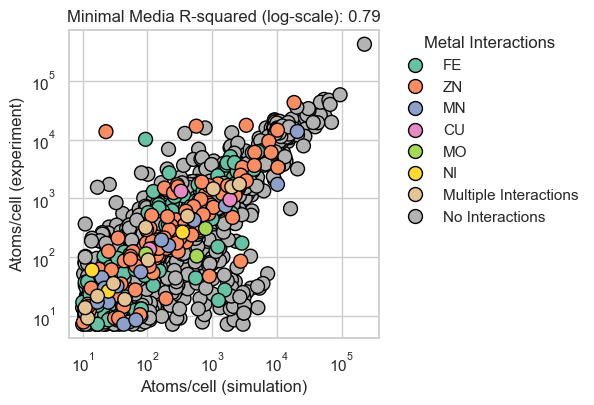

In [38]:
# preset parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 8})
sns.set(style="whitegrid", palette="Set2", context="notebook")

# figure 
plt.figure(figsize=(4, 4))
#sns.scatterplot(... , s=100, edgecolor='black', linewidth=1)

hue_order = ["FE", "ZN", "MN", "CU", "MO", "NI", "Multiple Interactions", "No Interactions"]

sns.scatterplot(x="Sim Protein Counts", y="MOPS minimal", data=minimal_media_comparison_df.to_pandas(), s=100, edgecolor='black', linewidth=1, hue="Metal Interactions", hue_order=hue_order)

# log scale
plt.xscale('log')
plt.yscale('log')


# calculate the R^2 value:
import scipy.stats as stats
slope, intercept, r_value, p_value, std_err = stats.linregress(minimal_media_comparison_df["Sim Protein Counts"], minimal_media_comparison_df["MOPS minimal"])

# plot specs:
plt.xlabel("Atoms/cell (simulation)")
plt.ylabel("Atoms/cell (experiment)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False, title="Metal Interactions")
plt.title("Minimal Media R-squared (log-scale): " + str(round(r_value**2, 2)))

R^2 value:  0.5730286039746666


Text(0.5, 1.0, 'Minimal Media R-squared (log-scale): 0.51')

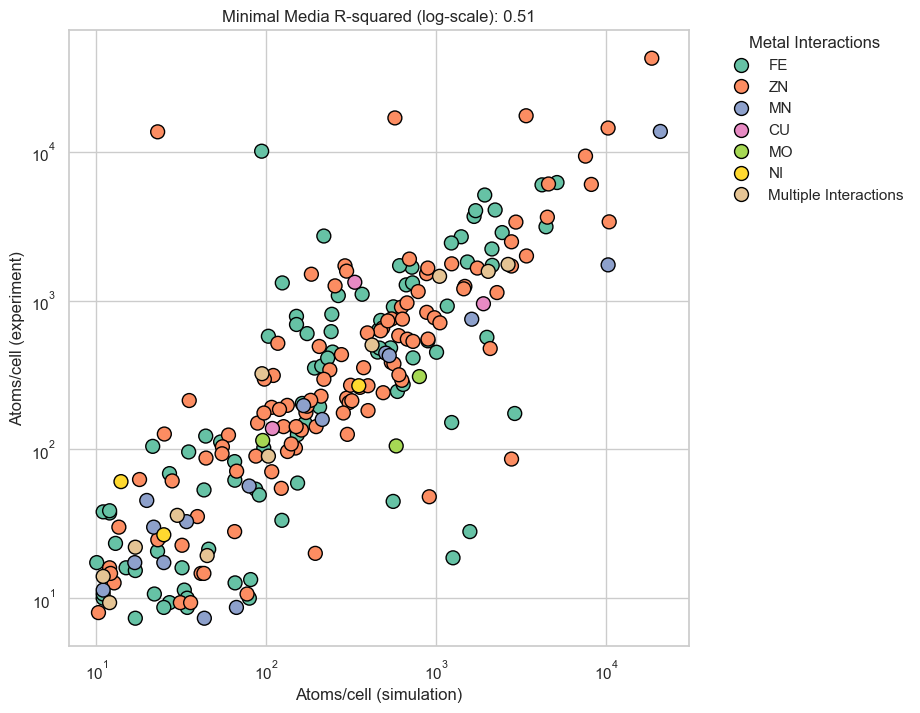

In [44]:
# use metal_interactions_df here instead to not have the "No Interactions" data:

# preset parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 8})
sns.set(style="whitegrid", palette="Set2", context="notebook")

# figure 
plt.figure(figsize=(8, 8))
hue_order = ["FE", "ZN", "MN", "CU", "MO", "NI", "Multiple Interactions"]


sns.scatterplot(x="Sim Protein Counts", y="MOPS minimal", data=metal_interactions_df.to_pandas(), s=100, edgecolor='black', linewidth=1, hue="Metal Interactions", hue_order=hue_order)

# log scale
plt.xscale('log')
plt.yscale('log')

# calculate the R^2 value:
import scipy.stats as stats
slope, intercept, r_value, p_value, std_err = stats.linregress(metal_interactions_df["Sim Protein Counts"], metal_interactions_df["MOPS minimal"])

# plot specs:
plt.xlabel("Atoms/cell (simulation)")
plt.ylabel("Atoms/cell (experiment)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False, title="Metal Interactions")
plt.title("Minimal Media R-squared (log-scale): " + str(round(r_value**2, 2)))